<a href="https://colab.research.google.com/github/hubcborja/Proyecto_DataMining_NN/blob/main/Proyecto_Mineria_Redes_Neuronales_HuberBorja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción juegos de rugby

# Librerías

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format


In [2]:
# ! pip install bs4
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
from html import unescape

# Extracción de datos

## Primer acercamiento con la librería BeautifulSoup a un partido en específico

Documentación librería
https://beautiful-soup-4.readthedocs.io/en/latest/

Código tomado y modificados de los pasos de la página: https://www.datacamp.com/es/tutorial/web-scraping-using-python

In [ ]:
url = "https://top14.lnr.fr/feuille-de-match/2025-2026/j15/11409-toulouse-pau/statistiques-du-match"
html = urlopen(url)


In [ ]:
soup = BeautifulSoup(html, 'lxml')
type(soup)


bs4.BeautifulSoup

In [ ]:
# Tener el título de la página
title = soup.title
print(title)


<title>Statistiques de Stade Toulousain - Section Paloise - J15 - 2025-2026 | Top 14 - Site Officiel</title>


In [ ]:
rows = soup.find_all('div')
# print(rows)


In [ ]:
url = "https://top14.lnr.fr/feuille-de-match/2025-2026/j15/11409-toulouse-pau/statistiques-du-match"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept-Language': 'es-ES,es;q=0.9',
    'Referer': 'https://top14.lnr.fr/'
}

response = requests.get(url, headers=headers)

print(f"Estado de la respuesta: {response.status_code}")
print(f"Longitud del contenido: {len(response.text)} caracteres")
print(f"Primeros 500 caracteres del HTML:\n{response.text[:500]}")


soup = BeautifulSoup(response.text, 'html.parser')
scripts = soup.find_all('script')
print(f"\nTotal de etiquetas <script> encontradas: {len(scripts)}")

Estado de la respuesta: 200
Longitud del contenido: 161705 caracteres
Primeros 500 caracteres del HTML:
<!DOCTYPE html>
<html lang="fr">
<head>
  <meta charset="utf-8" />
  <meta name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=1" />
  <meta name="csrf-token" content="1X7MUCeW1YGYVTpUV0wJ58Fzqja8SGMxFtQVwgKE" />

  <title>Statistiques de Stade Toulousain - Section Paloise - J15 - 2025-2026 | Top 14 - Site Officiel</title>
  <meta name="title" content="Statistiques de Stade Toulousain - Section Paloise - J15 - 2025-2026 | Top 14 - Site Officiel" />
  <met

Total de etiquetas <script> encontradas: 8


In [ ]:
# <div class="match-header__season-day">
#                   Match terminé - J15 - 24/01/2026 - 21h00
#               </div>

#Si quiero extraer la fecha

url = "https://top14.lnr.fr/feuille-de-match/2025-2026/j15/11409-toulouse-pau/statistiques-du-match"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')
fecha = soup.find('div', class_='match-header__season-day')
fecha = fecha.get_text(strip=True) if fecha else "N/A"
fecha = "-".join(fecha.split("-")[2:])
fecha


' 24/01/2026 - 21h00'

## Extracción estadísticas del partido

In [ ]:
# URL del partido
url = "https://top14.lnr.fr/feuille-de-match/2024-2025/j24/11035-pau-toulon/statistiques-du-match"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

#Función para extraer estadísticas del partido
def extraer_resumen_partido(url):
    print(f" Extrayendo datos generales de: {url}")
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Obtener el Resultado Final
    marcador_tag = soup.find('div', class_='title--large')
    marcador = marcador_tag.get_text(strip=True) if marcador_tag else "N/A"

    # Obtener fecha
    fecha = soup.find('div', class_='match-header__season-day')
    fecha = fecha.get_text(strip=True) if fecha else "N/A"
    partes = fecha.split("-")
    fecha = "-".join(partes[-2:]).strip()
    formato = "%d/%m/%Y - %Hh%M"
    fecha = datetime.strptime(fecha, formato)

    # Identificar Equipos
    equipo_local = soup.find_all('a', class_='match-header-club__title')[0].get_text(strip=True)
    equipo_visitante = soup.find_all('a', class_='match-header-club__title')[1].get_text(strip=True)

    print(f"Resultado Final: {equipo_local} {marcador} {equipo_visitante}, Fecha: {fecha}")

    # Extraer grupos de estadísticas (Points, Domination, Faltas, etc.)
    grupos = soup.find_all('div', class_='match-statistics__group')

    stats_totales = []

    for grupo in grupos:
        # Extraer el título de la categoría
        categoria = grupo.find('h2', class_='match-statistics__title')
        if not categoria: continue
        nombre_categoria = categoria.get_text(strip=True)

        # Extraer cada barra de estadística dentro del grupo
        filas = grupo.find_all('div', class_='stats-bar')
        for fila in filas:
            metrica = fila.find('div', class_='stats-bar__title').get_text(strip=True)
            valor_local = fila.find('div', class_='stats-bar__val--left').get_text(strip=True)
            valor_visitante = fila.find('div', class_='stats-bar__val--right').get_text(strip=True)

            stats_totales.append({
                'Categoría': nombre_categoria,
                'Métrica': metrica,
                equipo_local: valor_local,
                equipo_visitante: valor_visitante
            })

        df_match_stats_t=pd.DataFrame(stats_totales)
        df_match_stats_t['categoria_metrica']=df_match_stats_t['Categoría']+'_'+df_match_stats_t['Métrica']
        df_match_stats_t.drop(columns=['Categoría', 'Métrica'], inplace=True)
        marcador_l = "-".join(marcador.split("-")[:1])
        marcador_v = "-".join(marcador.split("-")[1:])
        marcadores=[marcador_l, marcador_v, 'Resultado']
        oponente=[equipo_visitante, equipo_local , 'Oponente']
        df_match_stats_t.loc[len(df_match_stats_t)] = marcadores
        df_match_stats_t.loc[len(df_match_stats_t)] = oponente
        df_match_stats_t=df_match_stats_t.set_index('categoria_metrica').T
        df_match_stats_t['fecha']=fecha
        df_match_stats_t=df_match_stats_t.reset_index()
        df_match_stats_t = df_match_stats_t.rename(columns={'index': 'equipo'})
    return df_match_stats_t


df_match_stats = extraer_resumen_partido(url)

display(df_match_stats)

 Extrayendo datos generales de: https://top14.lnr.fr/feuille-de-match/2024-2025/j24/11035-pau-toulon/statistiques-du-match
Resultado Final: Section Paloise 25 - 21 RC Toulon, Fecha: 2025-05-17 16:30:00


categoria_metrica,equipo,Points_Essais accordés,Domination_Possession de la balle,Domination_Occupation,Domination_Possession dans son camp,Domination_Possession dans le camp adverse,Domination_Possession 22m adverses,Actions_Mêlées obtenues,Actions_Mêlées perdues,Actions_Mêlées gagnées,Actions_Mêlées refaites,Actions_Touches obtenues,Actions_Touches gagnées sur son propre lancer,Actions_Touches gagnées sur lancer adverse,Fautes_En-avant commis,Fautes_Pénalités réussies,Fautes_Pénalités concédées,Plaquages et ballons joués_Plaquages réussis,Plaquages et ballons joués_Plaquages offensifs réussis,Plaquages et ballons joués_Plaquages manqués,Plaquages et ballons joués_Ballons joués au pied,Plaquages et ballons joués_Ballons passés,Resultado,Oponente,fecha
0,Section Paloise,3,49 %,47 %,39 %,52 %,47 %,10,1,8,1,13,12,2,6,2,10,113,7,32,30,104,25,RC Toulon,2025-05-17 16:30:00
1,RC Toulon,3,51 %,53 %,61 %,48 %,53 %,7,0,7,0,15,13,0,9,0,8,124,6,18,25,156,21,Section Paloise,2025-05-17 16:30:00


## Extracción estadísticas de los jugadores

Código corregido con asistente Gemini

In [22]:
# URL del partido (Toulouse vs Pau)
url = "https://top14.lnr.fr/feuille-de-match/2025-2026/j17/11422-paris-toulouse/statistiques-du-match"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

#Función para extraer estadísticas de los jugadores del partido
def extraer_rugby_data_jugadores(url):
    print(f"Iniciando extracción de jugadores en: {url}")
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Buscar los componentes <players-ranking>
    ranking_tags = soup.find_all('players-ranking')

    if len(ranking_tags) < 2:
        print("No se encontraron los datos de los jugadores. Verifica la conexión.")
        return None

    # Obtener fecha
    fecha = soup.find('div', class_='match-header__season-day')
    fecha = fecha.get_text(strip=True) if fecha else "N/A"
    partes = fecha.split("-")
    fecha = "-".join(partes[-2:]).strip()
    formato = "%d/%m/%Y - %Hh%M"
    fecha = datetime.strptime(fecha, formato)

    all_players = []

    # Nombres de los equipos
    equipo_local = soup.find_all('a', class_='match-header-club__title')[0].get_text(strip=True)
    equipo_visitante = soup.find_all('a', class_='match-header-club__title')[1].get_text(strip=True)
    equipos = [equipo_local, equipo_visitante]

    for idx, tag in enumerate(ranking_tags):
        raw_json = tag.get(':ranking')
        if raw_json:
            decoded_json = unescape(raw_json)
            data_list = json.loads(decoded_json)

            for p in data_list:
                all_players.append({
                    'Equipo': equipos[idx],
                    'Nombre': p['player']['name'],
                    'Posicion': p['position'],
                    'Minutos': int(p['minutesPlayed']),
                    'Puntos': int(p['nbPoints']),
                    'Essais': int(p['nbEssais']),
                    'Offload': int(p['offload']),
                    'Franchissement': int(p['lineBreak']),
                    'Tackles_Ok': int(p['totalSuccessfulTackles']),
                    'Tarjetas_Amarillas': int(p['nbCartonsJaunes']),
                    'Tarjetas_Rojas': int(p['nbCartonsRouges'])
                })

    all_players=pd.DataFrame(all_players)
    all_players['fecha']=fecha

    return all_players

# EJECUCIÓN
df_final = extraer_rugby_data_jugadores(url)

if df_final is not None:
    print(f"Se cargaron {len(df_final)} jugadores.")
    display(df_final.sort_values(by='Puntos', ascending=False).head(10))


Iniciando extracción de jugadores en: https://top14.lnr.fr/feuille-de-match/2025-2026/j17/11422-paris-toulouse/statistiques-du-match
Se cargaron 46 jugadores.


,Equipo,Nombre,Posicion,Minutos,Puntos,Essais,Offload,Franchissement,Tackles_Ok,Tarjetas_Amarillas,Tarjetas_Rojas,fecha
6,Stade Français Paris,Louis CARBONEL,Demi d'ouverture,80,9,0,1,0,4,0,0,2026-02-15 21:05:00
33,Stade Toulousain,V. DELPY,Demi d'ouverture,80,8,0,0,0,3,0,0,2026-02-15 21:05:00
34,Stade Toulousain,Efrain ELIAS,2ème ligne,72,5,1,0,0,3,0,0,2026-02-15 21:05:00
3,Stade Français Paris,P. AZAGOH KOUADIO,2ème ligne,57,0,0,0,0,15,0,0,2026-02-15 21:05:00
2,Stade Français Paris,M. ALO EMILE,Pilier,51,0,0,0,0,5,0,0,2026-02-15 21:05:00
0,Stade Français Paris,Paul ABADIE,Centre,20,0,0,0,0,3,0,0,2026-02-15 21:05:00
5,Stade Français Paris,Romain BRIATTE,Troisième ligne aile,80,0,0,0,0,15,0,0,2026-02-15 21:05:00
7,Stade Français Paris,Peniasi DAKUWAQA,Ailier,69,0,0,0,0,2,1,0,2026-02-15 21:05:00
8,Stade Français Paris,L. FOURSANS BOURDETTE,Centre,0,0,0,0,0,0,0,0,2026-02-15 21:05:00
9,Stade Français Paris,P. GABRILLAGUES,2ème ligne,80,0,0,0,0,18,0,0,2026-02-15 21:05:00


## Extracción juegos temporadas


In [ ]:
journee=['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10', 'j11', 'j12', 'j13', 'j14',
         'j15', 'j16', 'j17', 'j18', 'j19', 'j20', 'j21', 'j22', 'j23', 'j24', 'j25', 'j26',
         'barrage', 'access-top-14', 'demi-finale', 'finale']
saisons=['2025-2026', '2024-2025', '2023-2024', '2022-2023', '2021-2022']

urls_journees=[]

# Creacion de los url por jornada y temporada a buscar para extraer las url de los partidos
for s in saisons:
  for j in journee:
    url = f"https://top14.lnr.fr/calendrier-et-resultats/{s}/{j}"
    urls_journees.append(url)

urls_match=[]

# Busqueda de las url de cada partido en cada jornada
for url in urls_journees:
    html = urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    link_match = [link.get('href') for link in soup.find_all('a', class_='match-line__score')]
    urls_match.append(link_match)
    time.sleep(5)

# Volver el resultado en un vector para exportarlo y tener la base de las url por partido
urls_planas = [match_url for jornada in urls_match for match_url in jornada]
urls_planas = [url for url in urls_planas if url]

separator="/"
urls_scarp=[]
for url in urls_planas:
    ult_s=separator.join([url, 'statistiques-du-match'])
    urls_scarp.append(ult_s)

urls_scarp_pd=pd.DataFrame(urls_scarp, columns=['url_match'])
print("Total de partidos encontrados: ", len(urls_scarp_pd))
urls_scarp_pd.to_csv('urls_scrapping_top14.csv', index=False)

Total de partidos encontrados:  870


## Extracción de datos de los juegos recuperados.  

In [ ]:
datos_partidos_top14=[]
datos_jugadores_top14=[]

for url in urls_scarp:
  try:
    df_match_stats = extraer_resumen_partido(url)
    datos_partidos_top14.append(df_match_stats)
    df_jugadores=extraer_rugby_data_jugadores(url)
    datos_jugadores_top14.append(df_jugadores)
    time.sleep(2)
  except Exception as e:
        print(f"Error en {url}: {e}")
        continue

# Unificar todo
top14_partidos = pd.concat(datos_partidos_top14, ignore_index=True)
top14_jugadores = pd.concat(datos_jugadores_top14, ignore_index=True)

# Exportar a CSV
top14_partidos.to_csv('top14_partidos_2021_2026.csv', index=False)
top14_jugadores.to_csv('top14_jugadores_2021_2026.csv', index=False)

 Extrayendo datos generales de: https://top14.lnr.fr/feuille-de-match/2025-2026/j1/11311-paris-montauban/statistiques-du-match
Resultado Final: Stade Français Paris 47 - 24 US Montauban, Fecha: 2025-09-06 13:00:00
Iniciando extracción de jugadores en: https://top14.lnr.fr/feuille-de-match/2025-2026/j1/11311-paris-montauban/statistiques-du-match
 Extrayendo datos generales de: https://top14.lnr.fr/feuille-de-match/2025-2026/j1/11313-perpignan-bayonne/statistiques-du-match
Resultado Final: USA Perpignan 19 - 26 Aviron Bayonnais, Fecha: 2025-09-06 15:00:00
Iniciando extracción de jugadores en: https://top14.lnr.fr/feuille-de-match/2025-2026/j1/11313-perpignan-bayonne/statistiques-du-match
 Extrayendo datos generales de: https://top14.lnr.fr/feuille-de-match/2025-2026/j1/11308-castres-pau/statistiques-du-match
Resultado Final: Castres Olympique 15 - 17 Section Paloise, Fecha: 2025-09-06 17:00:00
Iniciando extracción de jugadores en: https://top14.lnr.fr/feuille-de-match/2025-2026/j1/11308-

In [ ]:
top14_partidos

categoria_metrica,equipo,Points_Essais accordés,Domination_Possession de la balle,Domination_Occupation,Domination_Possession dans son camp,Domination_Possession dans le camp adverse,Domination_Possession 22m adverses,Actions_Mêlées obtenues,Actions_Mêlées perdues,Actions_Mêlées gagnées,Actions_Mêlées refaites,Actions_Touches obtenues,Actions_Touches gagnées sur son propre lancer,Actions_Touches gagnées sur lancer adverse,Fautes_En-avant commis,Fautes_Pénalités réussies,Fautes_Pénalités concédées,Plaquages et ballons joués_Plaquages réussis,Plaquages et ballons joués_Plaquages offensifs réussis,Plaquages et ballons joués_Plaquages manqués,Plaquages et ballons joués_Ballons joués au pied,Plaquages et ballons joués_Ballons passés,Resultado,Oponente,fecha
0,Stade Français Paris,7,42 %,51 %,68 %,48 %,52 %,10,2,6,2,13,11,0,6,0,16,132,15,15,24,97,47,US Montauban,2025-09-06 13:00:00
1,US Montauban,4,58 %,49 %,32 %,52 %,48 %,7,3,3,1,14,14,0,7,0,9,96,2,26,23,199,24,Stade Français Paris,2025-09-06 13:00:00
2,USA Perpignan,3,58 %,53 %,56 %,47 %,54 %,4,1,3,0,17,16,0,8,0,11,88,4,23,26,159,19,Aviron Bayonnais,2025-09-06 15:00:00
3,Aviron Bayonnais,2,42 %,47 %,44 %,53 %,46 %,13,3,9,1,11,11,0,6,4,12,160,6,30,31,115,26,USA Perpignan,2025-09-06 15:00:00
4,Castres Olympique,2,48 %,54 %,74 %,45 %,54 %,7,2,5,0,15,12,0,5,1,15,134,15,13,19,114,15,Section Paloise,2025-09-06 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,Stade Toulousain,2,50 %,50 %,53 %,50 %,50 %,7,0,6,1,10,9,5,3,2,9,117,5,11,38,120,18,Castres Olympique,2022-06-17 21:05:00
1612,Montpellier Hérault Rugby,1,50 %,54 %,60 %,45 %,54 %,6,0,5,1,13,11,1,3,2,9,144,3,19,38,103,19,Union Bordeaux-Bègles,2022-06-18 21:05:00
1613,Union Bordeaux-Bègles,1,50 %,46 %,40 %,55 %,46 %,7,1,5,1,26,21,1,2,1,9,77,6,13,33,150,10,Montpellier Hérault Rugby,2022-06-18 21:05:00
1614,Castres Olympique,1,50 %,47 %,48 %,50 %,48 %,10,1,7,2,19,16,0,3,1,11,89,3,15,27,138,10,Montpellier Hérault Rugby,2022-06-24 20:45:00


In [ ]:
top14_partidos[top14_partidos['equipo']=='Stade Toulousain']

categoria_metrica,equipo,Points_Essais accordés,Domination_Possession de la balle,Domination_Occupation,Domination_Possession dans son camp,Domination_Possession dans le camp adverse,Domination_Possession 22m adverses,Actions_Mêlées obtenues,Actions_Mêlées perdues,Actions_Mêlées gagnées,Actions_Mêlées refaites,Actions_Touches obtenues,Actions_Touches gagnées sur son propre lancer,Actions_Touches gagnées sur lancer adverse,Fautes_En-avant commis,Fautes_Pénalités réussies,Fautes_Pénalités concédées,Plaquages et ballons joués_Plaquages réussis,Plaquages et ballons joués_Plaquages offensifs réussis,Plaquages et ballons joués_Plaquages manqués,Plaquages et ballons joués_Ballons joués au pied,Plaquages et ballons joués_Ballons passés,Resultado,Oponente,fecha
13,Stade Toulousain,4,53 %,56 %,61 %,44 %,55 %,3,1,2,0,17,13,1,6,2,9,133,9,15,28,166,34,ASM Clermont,2025-09-07 21:05:00
22,Stade Toulousain,4,69 %,67 %,74 %,33 %,65 %,11,1,9,1,19,17,0,5,1,11,60,1,5,11,208,31,USA Perpignan,2025-09-13 16:35:00
39,Stade Toulousain,2,55 %,48 %,49 %,53 %,48 %,8,5,2,1,15,11,0,5,0,14,79,3,18,24,151,14,Montpellier Hérault Rugby,2025-09-20 21:00:00
52,Stade Toulousain,9,65 %,58 %,86 %,42 %,58 %,7,1,4,2,19,16,0,3,0,10,81,7,6,19,158,59,Castres Olympique,2025-09-27 21:00:00
69,Stade Toulousain,3,53 %,44 %,36 %,57 %,44 %,5,2,3,0,14,7,2,6,3,7,135,9,20,30,122,26,Aviron Bayonnais,2025-10-05 21:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,Stade Toulousain,2,50 %,64 %,51 %,34 %,61 %,8,1,5,2,13,12,0,1,3,10,87,0,16,28,140,23,Stade Rochelais,2022-04-30 21:05:00
1589,Stade Toulousain,2,50 %,67 %,82 %,35 %,67 %,11,1,9,1,14,9,2,5,4,9,94,2,16,37,102,26,CA Brive,2022-05-21 21:05:00
1602,Stade Toulousain,12,50 %,43 %,34 %,56 %,42 %,6,0,5,1,17,15,0,3,0,7,64,0,11,22,146,80,Biarritz Olympique PB,2022-06-05 21:05:00
1606,Stade Toulousain,4,50 %,50 %,48 %,49 %,51 %,10,3,4,3,9,8,0,1,3,11,138,7,26,28,85,33,Stade Rochelais,2022-06-11 21:05:00


In [ ]:
top14_jugadores

,Equipo,Nombre,Posicion,Minutos,Puntos,Essais,Offload,Franchissement,Tackles_Ok,Tarjetas_Amarillas,fecha
0,Stade Français Paris,M. ALO EMILE,Pilier,51,0,0,0,0,9,0,2025-09-06 13:00:00
1,Stade Français Paris,Paul ALO EMILE,Pilier,51,0,0,0,0,11,0,2025-09-06 13:00:00
2,Stade Français Paris,P. AZAGOH KOUADIO,Centre,26,0,0,0,0,4,0,2025-09-06 13:00:00
3,Stade Français Paris,Romain BRIATTE,Troisième ligne aile,55,0,0,0,0,11,1,2025-09-06 13:00:00
4,Stade Français Paris,Louis CARBONEL,Demi d'ouverture,80,17,1,1,2,5,0,2025-09-06 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...
36522,Montpellier Hérault Rugby,Robert RODGERS,Centre,18,0,0,0,0,5,0,2022-06-24 20:45:00
36523,Montpellier Hérault Rugby,J. SERFONTEIN,Centre,62,0,0,1,0,13,0,2022-06-24 20:45:00
36524,Montpellier Hérault Rugby,H. THOMAS,Centre,22,0,0,0,0,2,0,2022-06-24 20:45:00
36525,Montpellier Hérault Rugby,Florian VERHAEGHE,2ème ligne,65,5,1,0,0,11,0,2022-06-24 20:45:00


In [ ]:
top14_jugadores[top14_jugadores['Nombre']=="Antoine DUPONT"]

,Equipo,Nombre,Posicion,Minutos,Puntos,Essais,Offload,Franchissement,Tackles_Ok,Tarjetas_Amarillas,fecha
3508,Stade Toulousain,Antoine DUPONT,Centre,30,0,0,0,0,1,0,2025-11-29 21:00:00
3850,Stade Toulousain,Antoine DUPONT,Centre,26,0,0,1,1,3,0,2025-12-20 21:00:00
4195,Stade Toulousain,Antoine DUPONT,Demi de mêlée,60,10,2,4,3,1,0,2025-12-28 21:05:00
4746,Stade Toulousain,Antoine DUPONT,Demi de mêlée,70,0,0,2,0,6,1,2026-01-24 21:00:00
7357,Stade Toulousain,Antoine DUPONT,Centre,35,15,3,2,1,0,0,2024-10-12 21:05:00
7702,Stade Toulousain,Antoine DUPONT,Demi de mêlée,80,0,0,4,0,8,0,2024-10-19 21:05:00
8044,Stade Toulousain,Antoine DUPONT,Demi de mêlée,80,0,0,2,1,7,0,2024-10-27 21:05:00
15742,Stade Toulousain,Antoine DUPONT,Centre,34,0,0,0,0,8,0,2023-11-11 15:00:00
16306,Stade Toulousain,Antoine DUPONT,Demi d'ouverture,80,0,0,0,0,4,0,2023-11-18 21:05:00
16603,Stade Toulousain,Antoine DUPONT,Demi de mêlée,70,0,0,4,0,8,0,2023-11-25 21:05:00


# Exploración de los datos
## Importación de los datos desde el repositorio en github

Se extraen nuevamente la base de datos desde lo exportado y subido a Github

In [43]:
top14_jugadores=pd.read_csv("https://raw.githubusercontent.com/hubcborja/Proyecto_DataMining_NN/refs/heads/main/top14_jugadores_2021_2026.csv")
top14_partidos=pd.read_csv("https://raw.githubusercontent.com/hubcborja/Proyecto_DataMining_NN/refs/heads/main/top14_partidos_2021_2026.csv")

In [51]:
print(top14_partidos.dtypes)

equipo                                   object
puntos_trys_concedidos                    int64
posesion_pelota                         float64
ocupacion_sobre_terreno_rival           float64
posesion_sobre_terreno_propio           float64
posesion_sobre_terreno_rival            float64
posesion_sobre22m_rival                 float64
scrum_obtenidos                           int64
scrum_perdidos                            int64
scrum_ganados                             int64
scrum_reiniciados                         int64
lineouts_obtenidos                        int64
lineouts_ganados                          int64
lineouts_ganados_rival                    int64
knock_on                                  int64
penales_anotados                          int64
penales_cometidos                         int64
tackles_exitoso                           int64
tackle_defensivo_exitoso                  int64
tackle_fallido                            int64
free_kick                               

In [45]:
top14_partidos.head(1)

,equipo,Points_Essais accordés,Domination_Possession de la balle,Domination_Occupation,Domination_Possession dans son camp,Domination_Possession dans le camp adverse,Domination_Possession 22m adverses,Actions_Mêlées obtenues,Actions_Mêlées perdues,Actions_Mêlées gagnées,Actions_Mêlées refaites,Actions_Touches obtenues,Actions_Touches gagnées sur son propre lancer,Actions_Touches gagnées sur lancer adverse,Fautes_En-avant commis,Fautes_Pénalités réussies,Fautes_Pénalités concédées,Plaquages et ballons joués_Plaquages réussis,Plaquages et ballons joués_Plaquages offensifs réussis,Plaquages et ballons joués_Plaquages manqués,Plaquages et ballons joués_Ballons joués au pied,Plaquages et ballons joués_Ballons passés,Resultado,Oponente,fecha
0,Stade Français Paris,7,42 %,51 %,68 %,48 %,52 %,10,2,6,2,13,11,0,6,0,16,132,15,15,24,97,47,US Montauban,2025-09-06 13:00:00


In [50]:
print(top14_jugadores.dtypes)

equipo                                  object
nombre_jugador                          object
Posicion                              category
minutos_jugados                          int64
puntos                                   int64
Trys_anotados                            int64
offload_descarga_en_contacto             int64
linebreak_quiebre_de_linea               int64
tackles_exitosos                         int64
Tarjetas_Amarillas                       int64
fecha                           datetime64[ns]
dtype: object


In [46]:
top14_jugadores.head(1)

,Equipo,Nombre,Posicion,Minutos,Puntos,Essais,Offload,Franchissement,Tackles_Ok,Tarjetas_Amarillas,fecha
0,Stade Français Paris,M. ALO EMILE,Pilier,51,0,0,0,0,9,0,2025-09-06 13:00:00


Cambio de nombre de columnas al español

In [47]:
diccionario_partido={
    'Points_Essais accordés':'puntos_trys_concedidos',
    'Domination_Possession de la balle':'posesion_pelota',
    'Domination_Occupation':'ocupacion_sobre_terreno_rival',
    'Domination_Possession dans son camp':'posesion_sobre_terreno_propio',
    'Domination_Possession dans le camp adverse':'posesion_sobre_terreno_rival',
    'Domination_Possession 22m adverses':'posesion_sobre22m_rival',
    'Actions_Mêlées obtenues':'scrum_obtenidos',
    'Actions_Mêlées perdues':'scrum_perdidos',
    'Actions_Mêlées gagnées':'scrum_ganados',
    'Actions_Mêlées refaites':'scrum_reiniciados',
    'Actions_Touches obtenues':'lineouts_obtenidos',
    'Actions_Touches gagnées sur son propre lancer':'lineouts_ganados',
    'Actions_Touches gagnées sur lancer adverse':'lineouts_ganados_rival',
    'Fautes_En-avant commis':'knock_on',
    'Fautes_Pénalités réussies':'penales_anotados',
    'Fautes_Pénalités concédées':'penales_cometidos',
    'Plaquages et ballons joués_Plaquages réussis':'tackles_exitoso',
    'Plaquages et ballons joués_Plaquages offensifs réussis':'tackle_defensivo_exitoso',
    'Plaquages et ballons joués_Plaquages manqués':'tackle_fallido',
    'Plaquages et ballons joués_Ballons joués au pied':'free_kick',
    'Plaquages et ballons joués_Ballons passés':'balones_pasados'
}

top14_partidos = top14_partidos.rename(columns=diccionario_partido)

diccionario_jugadores={
    'Equipo':'equipo',
    'Nombre':'nombre_jugador',
    'Minutos':'minutos_jugados',
    'Puntos':'puntos',
    'Essais':'Trys_anotados',
    'Offload':'offload_descarga_en_contacto',
    'Franchissement':'linebreak_quiebre_de_linea',
    'Tackles_Ok':'tackles_exitosos'
}


top14_jugadores = top14_jugadores.rename(columns=diccionario_jugadores)

## Limpieza de tipo de datos

In [48]:
#para las fechas

top14_partidos['fecha'] = pd.to_datetime(top14_partidos['fecha'])
top14_jugadores['fecha'] = pd.to_datetime(top14_jugadores['fecha'])

# para porcentajes

columnas_porcentaje = [
    'posesion_pelota', 'ocupacion_sobre_terreno_rival',
    'posesion_sobre_terreno_propio', 'posesion_sobre_terreno_rival',
    'posesion_sobre22m_rival'
]

for col in columnas_porcentaje:
    top14_partidos[col] = top14_partidos[col].str.replace('%', '').str.strip().astype(float) / 100

# categorías de jugadores

top14_jugadores['Posicion']=top14_jugadores['Posicion'].astype('category')

## Estadíticas y correlación de los datos


In [60]:
top14_partidos.describe()

,puntos_trys_concedidos,posesion_pelota,ocupacion_sobre_terreno_rival,posesion_sobre_terreno_propio,posesion_sobre_terreno_rival,posesion_sobre22m_rival,scrum_obtenidos,scrum_perdidos,scrum_ganados,scrum_reiniciados,lineouts_obtenidos,lineouts_ganados,lineouts_ganados_rival,knock_on,penales_anotados,penales_cometidos,tackles_exitoso,tackle_defensivo_exitoso,tackle_fallido,free_kick,balones_pasados,Resultado,fecha
count,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616.00,1616
mean,2.76,0.50,0.50,0.50,0.50,0.50,7.26,0.98,5.29,1.00,14.22,11.28,1.33,4.74,2.07,11.01,117.12,6.96,19.70,25.38,123.03,24.58,2023-12-03 12:13:41.287128832
min,0.00,0.31,0.26,0.03,0.23,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2021-09-04 14:00:00
25%,1.00,0.48,0.45,0.40,0.45,0.46,5.00,0.00,4.00,0.00,12.00,9.00,0.00,3.00,1.00,9.00,94.00,3.00,14.00,21.00,98.00,17.00,2022-09-17 16:30:00
50%,2.00,0.50,0.50,0.50,0.50,0.50,7.00,1.00,5.00,1.00,14.00,11.00,1.00,5.00,2.00,11.00,115.00,6.00,19.00,25.00,120.00,23.00,2024-01-27 19:02:30
75%,4.00,0.52,0.55,0.60,0.55,0.54,9.00,2.00,7.00,2.00,17.00,13.00,2.00,6.00,3.00,13.00,138.00,10.00,24.00,30.00,146.00,31.00,2025-01-26 03:12:30
max,12.00,0.69,0.74,0.97,0.77,0.77,20.00,5.00,15.00,6.00,28.00,23.00,9.00,15.00,8.00,23.00,256.00,31.00,53.00,50.00,257.00,84.00,2026-02-15 21:05:00
std,1.89,0.05,0.08,0.16,0.08,0.07,2.92,1.00,2.31,1.01,3.68,3.42,1.28,2.48,1.55,3.17,33.30,4.81,7.85,7.05,36.07,11.84,NaN


In [61]:
top14_jugadores.describe()

,minutos_jugados,puntos,Trys_anotados,offload_descarga_en_contacto,linebreak_quiebre_de_linea,tackles_exitosos,Tarjetas_Amarillas,fecha
count,36527.00,36527.00,36527.00,36527.00,36527.00,36527.00,36527.00,36527
mean,51.24,1.02,0.12,0.35,0.19,5.05,0.03,2023-12-14 05:29:15.953130752
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2021-09-04 14:00:00
25%,29.00,0.00,0.00,0.00,0.00,2.00,0.00,2022-09-17 21:05:00
50%,54.00,0.00,0.00,0.00,0.00,4.00,0.00,2024-02-03 21:05:00
75%,79.00,0.00,0.00,1.00,0.00,7.00,0.00,2025-02-15 18:47:30
max,100.00,28.00,4.00,10.00,6.00,31.00,1.00,2026-02-15 21:05:00
std,24.49,2.84,0.36,0.69,0.50,3.92,0.18,NaN


In [41]:
#Se debe tener en cuenta que no son únicos debido a que hay información de todas las temporadas
#    y un jugador puede jugar en diferentes posiciones
print(top14_jugadores['Posicion'].value_counts())


Posicion
Centre                    15879
Ailier                     3222
2ème ligne                 3212
Pilier                     3211
Troisième ligne aile       3178
Talonneur                  1612
Troisième ligne centre     1592
Demi de mêlée              1547
Arrière                    1541
Demi d'ouverture           1533
Name: count, dtype: int64


mapa de correlacion entre variables numéricas

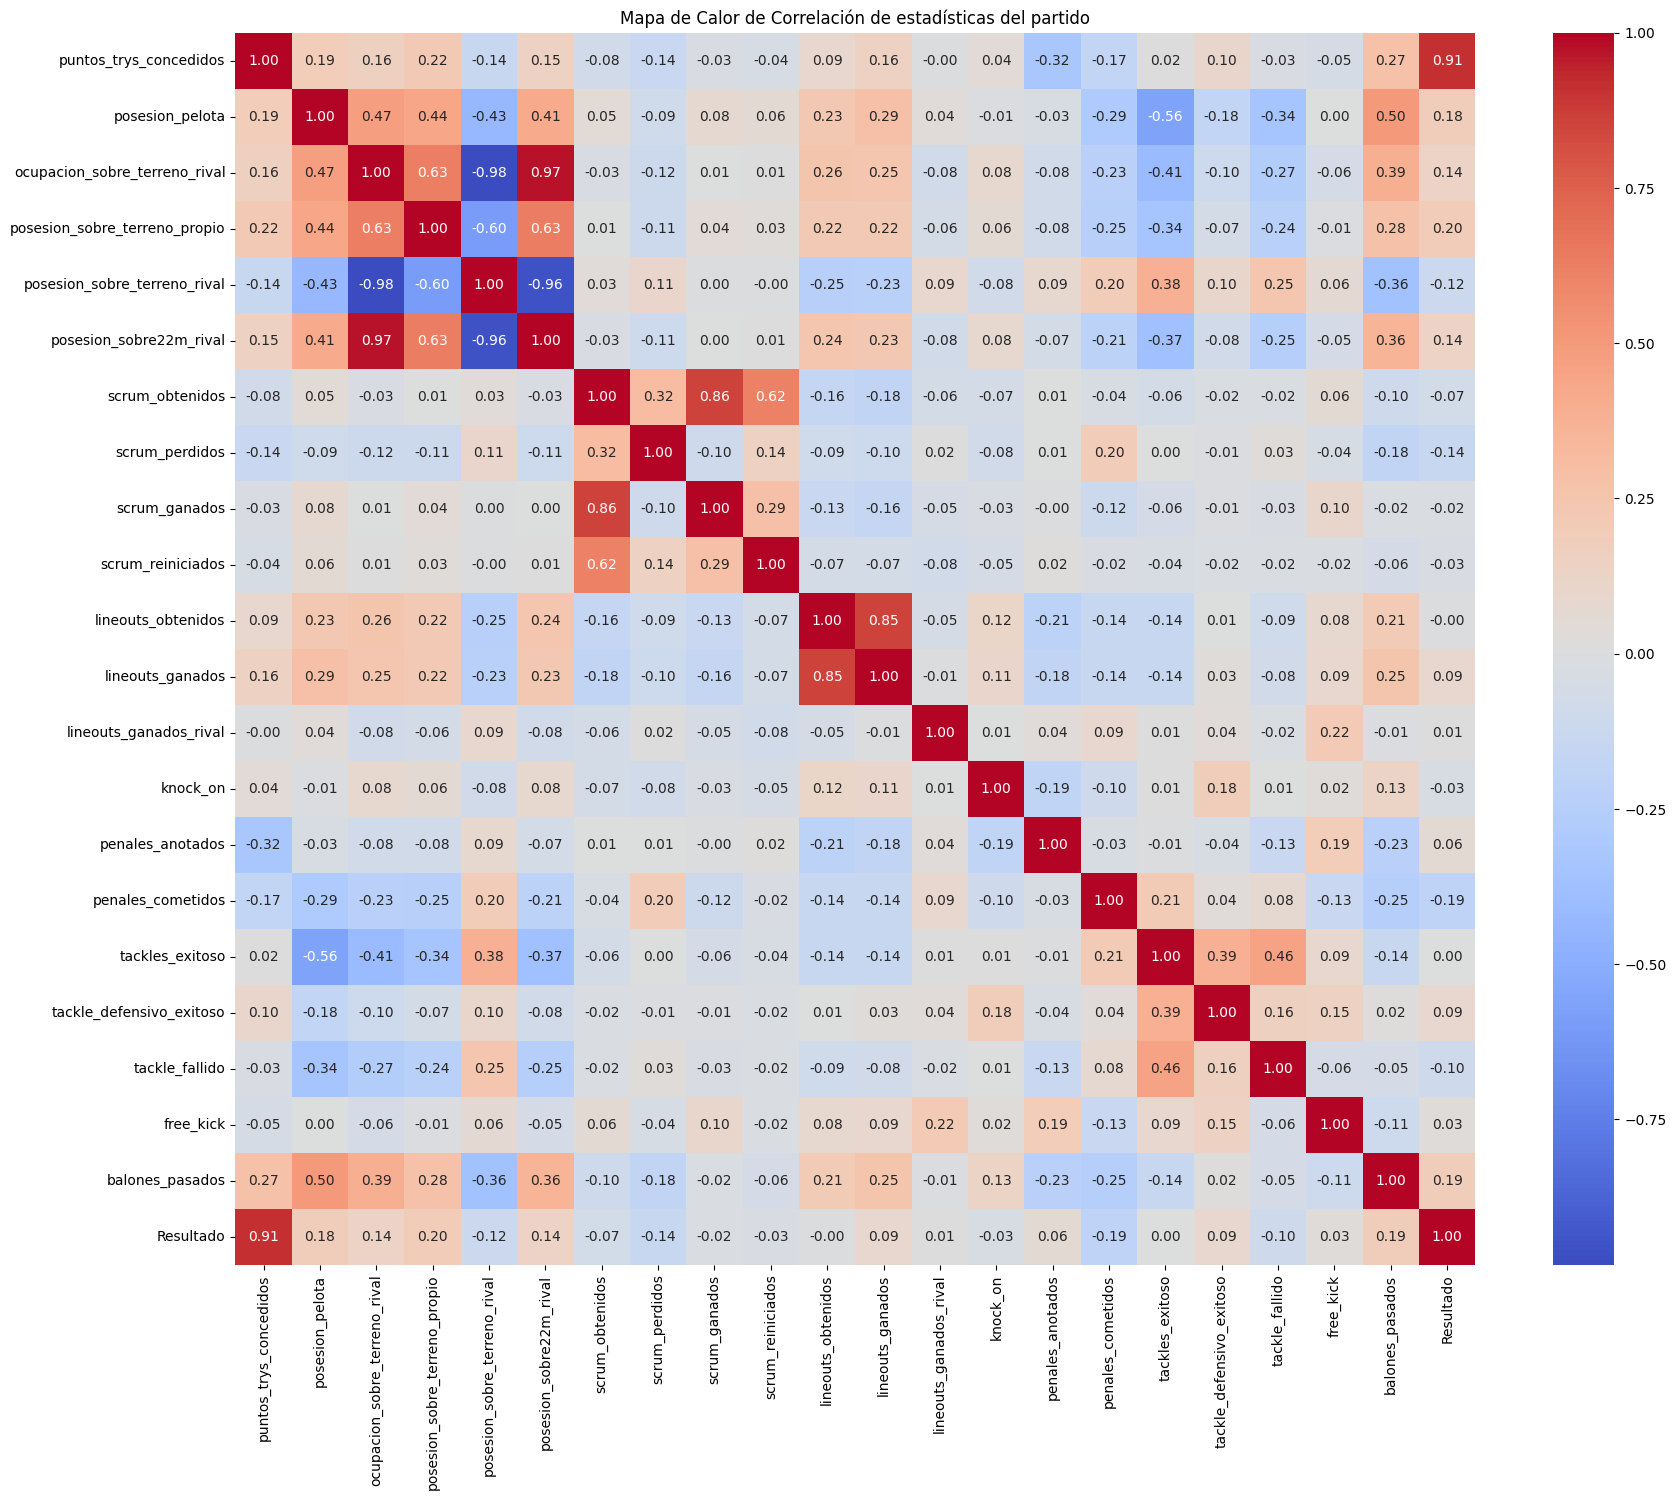

In [55]:
top14_partidos_num=top14_partidos.select_dtypes(include=['float64', 'int64'])
matriz_correlacion = top14_partidos_num.corr()

# Crear el mapa de calor
plt.figure(figsize=(20,16))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación de estadísticas del partido')
plt.show()

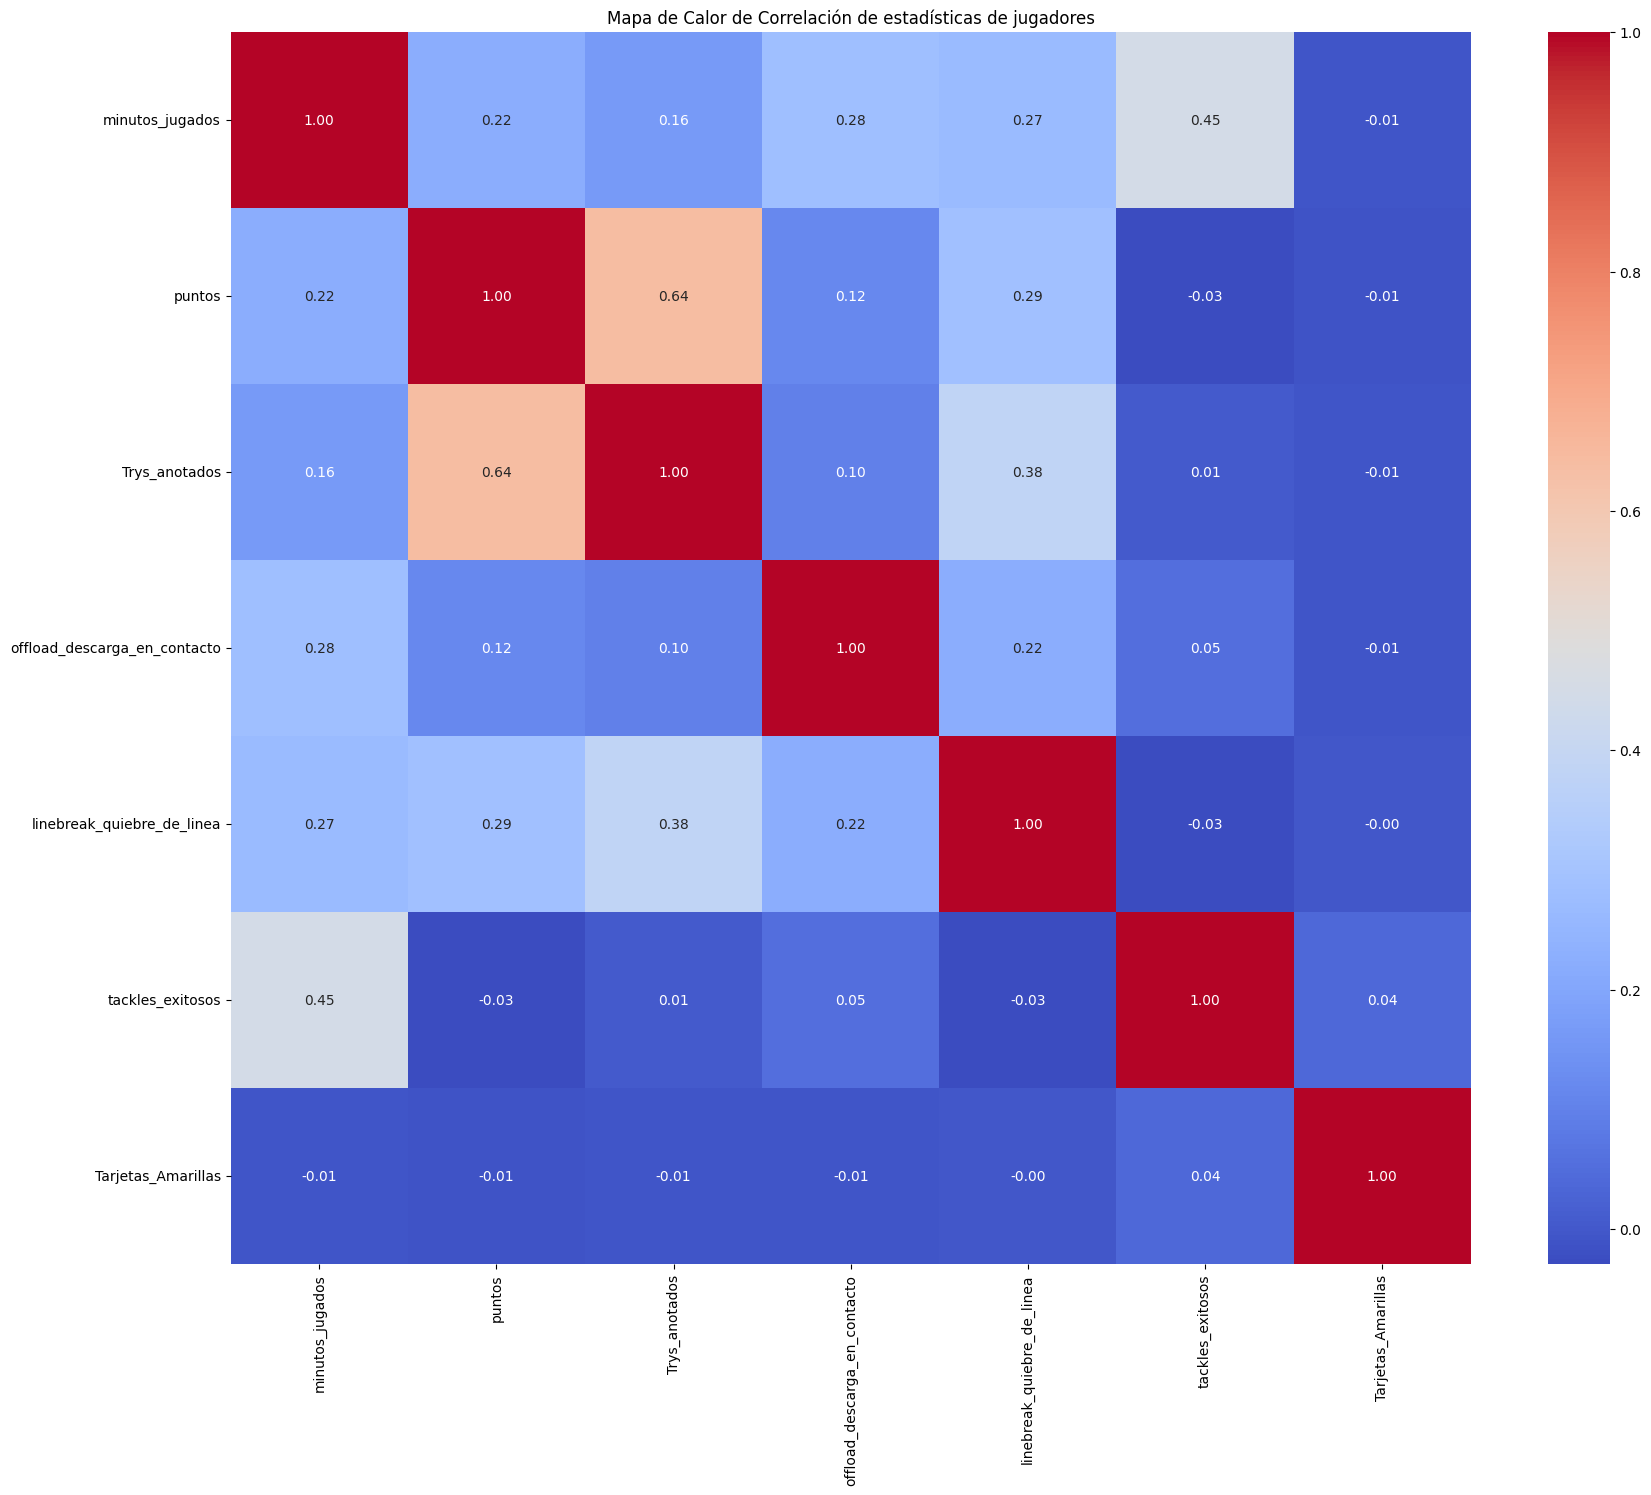

In [56]:
top14_jugadores_num=top14_jugadores.select_dtypes(include=['float64', 'int64'])
matriz_correlacion = top14_jugadores_num.corr()

# Crear el mapa de calor
plt.figure(figsize=(20,16))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación de estadísticas de jugadores')
plt.show()

# K means para etiquetado de equipos y jugadores

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Análisis para Jugadores:
Para n_clusters = 2, el score de silueta es: 0.4608
Para n_clusters = 3, el score de silueta es: 0.2727
Para n_clusters = 4, el score de silueta es: 0.3058
Para n_clusters = 5, el score de silueta es: 0.3279
Para n_clusters = 6, el score de silueta es: 0.3389
Para n_clusters = 7, el score de silueta es: 0.3575
Para n_clusters = 8, el score de silueta es: 0.3712
Para n_clusters = 9, el score de silueta es: 0.3397
Para n_clusters = 10, el score de silueta es: 0.3473


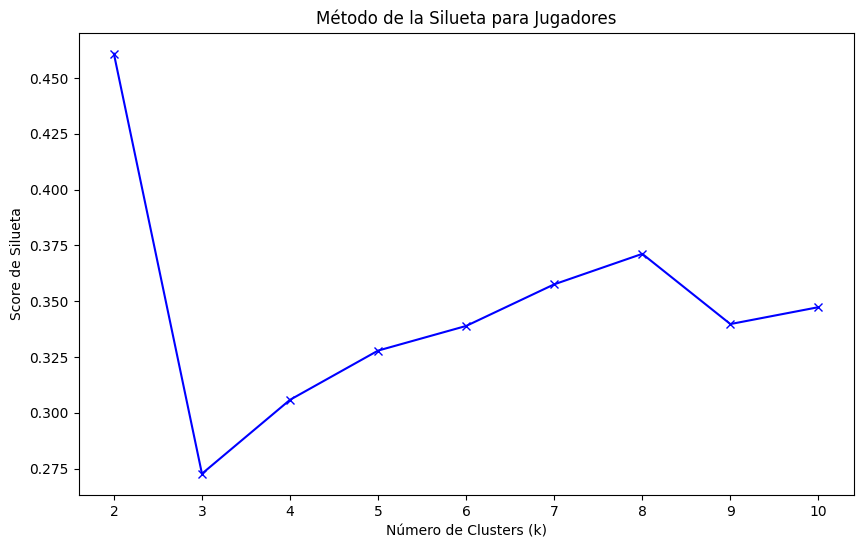


Análisis para Equipos (Promedios):
Para n_clusters = 2, el score de silueta es: 0.2653
Para n_clusters = 3, el score de silueta es: 0.3054
Para n_clusters = 4, el score de silueta es: 0.2473
Para n_clusters = 5, el score de silueta es: 0.2558
Para n_clusters = 6, el score de silueta es: 0.2348
Para n_clusters = 7, el score de silueta es: 0.1679
Para n_clusters = 8, el score de silueta es: 0.1844
Para n_clusters = 9, el score de silueta es: 0.1295
Para n_clusters = 10, el score de silueta es: 0.1155


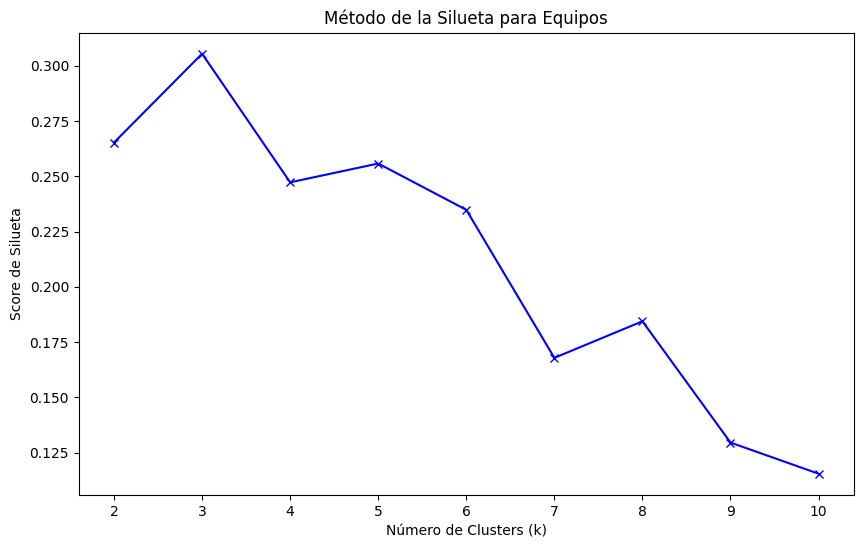

In [64]:
def preparar_y_silueta(df_num, titulo):
    # Escalar los datos
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_num)

    rango_n_clusters = range(2, 11)
    valores_silueta = []

    # Iterar para encontrar el cluster optimo
    for n_clusters in rango_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = clusterer.fit_predict(df_scaled)

        # Calcular el score de silueta
        silhouette_avg = silhouette_score(df_scaled, cluster_labels)
        valores_silueta.append(silhouette_avg)
        print(f"Para n_clusters = {n_clusters}, el score de silueta es: {silhouette_avg:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(rango_n_clusters, valores_silueta, 'bx-')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Score de Silueta')
    plt.title(f'Método de la Silueta para {titulo}')
    plt.show()

    return df_scaled

# Para Jugadores
print("Análisis para Jugadores:")
X_jugadores_scaled = preparar_y_silueta(top14_jugadores_num, "Jugadores")

# Para Equipos
top14_equipos_promedio = top14_partidos.groupby('equipo').mean(numeric_only=True)
print("\nAnálisis para Equipos:")
X_equipos_scaled = preparar_y_silueta(top14_equipos_promedio, "Equipos")